# Analysis of Tina simulation results

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import warnings

import os
import sys
import glob
import scipy.stats

# Import piezo/fatigue sensor libraries
sys.path.insert(0, "lib")
from piezo import Piezo
from fatigue_sensor import FatigueSensor, create_sensor

from matplotlib import rc
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.patches as patches

from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Create linestyles for black and white plots
ls = ["-","--",":","-."]
markers = ["o","s","d"]
clrs = ["k"]

linestyles = list()
for l in ls:
    for m in markers:
        for c in clrs:
            linestyles.append(m+l+c)

font_size = 18
params = {'legend.fontsize': 'large',
          'figure.figsize': (6.0, 4.0),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.size': font_size}
pylab.rcParams.update(params)

In [2]:
C2 = 4e-6  ## Select size of capacitor C2 (available data for 3, 4 and 5 uF)

In [3]:
sim_type = 'C2-%du'%(C2 * 1e6)
sim_param=['amp','V']
sim_path = '../data/raw/varying-vo1/' + sim_type
processed_data = '../data/processed/varying-vo1/'

In [4]:
from IPython.display import display, Markdown
mdfile = sim_path + '/Readme.md'
with open(mdfile, 'r') as fh:
    content = fh.read()

display(Markdown(content))

### Parameters

| **Parameter**  | **Value**              |
|----------------|------------------------|
| Op-amp (s2/s3) | OPA333                 |
| Vcc            | 3.3 V                  |
| Vee            | 0.0 V                  |
| R3             | 47 kOhm                |
| R4             | 10 MOhm                |
| R5             | 1 KOhm                 |
| C2             | 4 uF                   |
| Vo1 (DC Level) | 1.65                   |
| Vo1 (Signal)   | Sine wave              |
| Vo1 (A)        | 0.2-1.6V in 0.2V steps |
| Vo1 (f)        | 1-20Hz in 1Hz steps    |


### Data files

Data files format is .txt. Data files have a one-line header (first row) starting with the character *. Data follow. Columns are separated by '\t'.

Example: 

---
*Time 	vo1_phi[1]	vo1[1]	vo3[1]	vo2[1]

0	1.65000000219073	1.65362369158755	1.65000240451935	3.29997962313781

0.025	1.78036203802659	1.80971446653372	1.78009762006678	3.29998157908571

0.0287138182481702	1.80127776044844	1.83266661394274	1.80099169507382	3.29998186497682

0.0361414547445107	1.84493219384149	1.87826600650275	1.84462490147006	3.2999824303021

---

Each data file contains the following columns:
* Column 1: Time (s)
* Column 2: vo1_phi - Input signal of U3 ($v^{\phi}_{o1}$) (V)
* Column 3: vo1 - Input signal at non-inverting terminal of U2 ($v_{o1}$) (V)
* Column 4: vo3 - Ouput signal of U3 ($v_{o2}$) (V)
* Column 5: vo2 - Ouput signal of U2 ($v_{o3}$) (V)

## Create sensor

In [5]:
# Create sensor
sensor = create_sensor()
sensor.getFirstStage().setCf(2.5e-9)

## Load simulation datafiles (*optional*)

We will load the simulation files and format/store the data for later analysis. We will create a dictionary where keys are the simulated frequency ($f$) and the content is a Pandas dataframe with the data from each file.

In [6]:
def load_sim_files(sim_path, sim_param, verbose=False):
    # Get simulation filenames
    sim_files = glob.glob(sim_path + '/tcurve-*.txt')
    # Extract simulated params
    sim_param = np.array([file.split('tcurve-%s-'%(sim_param[0]))[1].split('%s.txt'%(sim_param[1]))[0] for file in sim_files])
    
    sim_database = dict()
    for p in sim_param:
        filename = [s for s in sim_files if p in s]
        if not filename:
            raise ValueError("Key %s does not exist in file list" % (p))
        if len(filename) > 1:
            raise ValueError("More than one file in file list with key %s" % (p))
        sim_database[p] = load_tina_single_datafile(filename[0], verbose=verbose)
    
    # Return dictionary with all files data and sim_param
    return {'sim_database': sim_database, 'sim_param': sim_param}

def load_tina_single_datafile(filename, verbose=False):
    # Create empty dictionary
    dout = dict()
    # Check filepath
    if not os.path.isfile(filename):
        print("File path {} does not exist. Exiting...".format(filename))
        sys.exit()
    if verbose == True:
        print("Processing %s..." % (filename))
    # Read file
    with open(filename) as fp:
        freq = None
        for line in fp:
            line_contents = line.strip().split('\t')
            if len(line_contents) != 5: 
                continue
            if '*' in line_contents[0]:
                # Remove '*' character from '*Time'
                line_contents[0] = line_contents[0][1:]
                # Extract frequency
                freq = str(int(line_contents[1].split('[')[1].split(']')[0]))
                # Add to dictionary
                if freq not in dout:
                    dout[freq] = pd.DataFrame(columns=line_contents)
                    if verbose == True: 
                        print("  Added f=%s to dictionary"%(freq))
                else:
                    warnings.warn("Warning...........[read_single_file] key %s already exists" % (f))
            else:
                if freq is not None:
                    dout[freq] = dout[freq].append(pd.Series(line_contents, 
                                                             index=dout[freq].columns.values.tolist()), 
                                                   ignore_index=True)
                else:
                    raise ValueError('Dataframe not created in dictionary')
    for f in dout:
        # Convert all columns of each dataframe in d to float64
        dout[f] = dout[f].apply(pd.to_numeric)
        dout[f] = dout[f].rename(
            columns={dout[f].columns.values[0]: "timestamp", 
                     "vo1_phi[%s]"%(f): "vo1_phi",
                     "vo1[%s]"%(f): "vo1",
                     "vo2[%s]"%(f): "vo2",
                     "vo3[%s]"%(f): "vo3"}
                      )
        dout[f] = dout[f].set_index('timestamp')
    # Get frequencies
    sim_freq = np.sort(np.fromiter(dout.keys(), dtype=int))
    # Return dataframe
    return { 'sim_database': dout, 'sim_freq': sim_freq }

def plot_dataset(dataset, peaks_troughs_hw=None, peaks_troughs_sw=None):
    
    x = dataset.index.values
    vo1 = dataset['vo1'].values
    vo1_phi = dataset['vo1_phi'].values
    vo2 = dataset['vo2'].values
    vo3 = dataset['vo3'].values
    
    if peaks_troughs_hw is not None:
        # Extract peaks
        time_peaks_hw = peaks_troughs_hw['time_peaks']
        peaks_hw = peaks_troughs_hw['peaks']
        # Extract troughs
        time_troughs_hw = peaks_troughs_hw['time_troughs']
        troughs_hw = peaks_troughs_hw['troughs']
        
        
    if peaks_troughs_sw is not None:
        # Extract peaks
        time_peaks_sw = peaks_troughs_sw['time_peaks']
        peaks_sw = peaks_troughs_sw['peaks']
        # Extract troughs
        time_troughs_sw = peaks_troughs_sw['time_troughs']
        troughs_sw = peaks_troughs_sw['troughs']

    # Create figure and axes
    fig = plt.figure(figsize=(8.0, 5.0))
    ax0 = fig.add_subplot(111)
    # Plot
    ax0.plot(x, vo1, label=r'$v_{o1}$', color=colors['saddlebrown'])
    ax0.plot(x, vo2, label=r'$v_{o2}$', color=colors['red'])
    ax0.plot(x, vo1_phi, label=r'$v^{\phi}_{o1}$', color=colors['goldenrod'])
    ax0.plot(x, vo3, label=r'$v_{o3}$', color=colors['darkolivegreen'])
    ncol = 3
    if peaks_troughs_hw is not None:
        ax0.plot(time_peaks_hw, peaks_hw, label='Peak/Trough (hw)', ls='', marker='*', ms='5', color=colors['red'])
        ax0.plot(time_troughs_hw, troughs_hw, ls='', marker='*', ms='5', color=colors['red'])
        
        ncol += 1
    if peaks_troughs_sw is not None:
        ax0.plot(time_peaks_sw, peaks_sw, label='Peak/Trough (sw)', ls='', marker='*', ms='5', color=colors['green'])
        ax0.plot(time_troughs_sw, troughs_sw, ls='', marker='*', ms='5', color=colors['green'])
        ncol += 1
        
    # Grid    
    ax0.grid(color='gray', linestyle='dotted')
    # Legend
    ax0.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=ncol,
            borderaxespad=0, frameon=True)
    
    # Axes labels
    ax0.set_ylabel('Voltage (V)')
    ax0.set_xlabel('Time (s)')
    
    # Some cosmetics
    ax0.spines['right'].set_visible(False)
    ax0.spines['top'].set_visible(False)
    ax0.yaxis.set_ticks_position('left')
    ax0.xaxis.set_ticks_position('bottom')

    # Adjust plot to plotting area
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Main processing functions

In [7]:
## Find intersection between vo3 and vo1_phi
# To find where $v_{o3}$ and $v^{\phi}_{o1}$ intersect with each other, 
# we use the solution implemented by Subhbinder available on 
# [GitHub](https://github.com/sukhbinder/intersection)
def __rect_inter_inner(x1,x2):
    n1=x1.shape[0]-1
    n2=x2.shape[0]-1
    X1=np.c_[x1[:-1],x1[1:]]
    X2=np.c_[x2[:-1],x2[1:]]
    S1=np.tile(X1.min(axis=1),(n2,1)).T
    S2=np.tile(X2.max(axis=1),(n1,1))
    S3=np.tile(X1.max(axis=1),(n2,1)).T
    S4=np.tile(X2.min(axis=1),(n1,1))
    return S1,S2,S3,S4

def __rectangle_intersection_(x1,y1,x2,y2):
    S1,S2,S3,S4=__rect_inter_inner(x1,x2)
    S5,S6,S7,S8=__rect_inter_inner(y1,y2)

    C1=np.less_equal(S1,S2)
    C2=np.greater_equal(S3,S4)
    C3=np.less_equal(S5,S6)
    C4=np.greater_equal(S7,S8)

    ii,jj=np.nonzero(C1 & C2 & C3 & C4)
    return ii,jj

def __intersection(x1,y1,x2,y2):
    """
    INTERSECTIONS Intersections of curves.
       Computes the (x,y) locations where two curves intersect.  The curves
       can be broken with NaNs or have vertical segments.
    usage:
    x,y=intersection(x1,y1,x2,y2)
        Example:
        a, b = 1, 2
        phi = np.linspace(3, 10, 100)
        x1 = a*phi - b*np.sin(phi)
        y1 = a - b*np.cos(phi)
        x2=phi
        y2=np.sin(phi)+2
        x,y=intersection(x1,y1,x2,y2)
        plt.plot(x1,y1,c='r')
        plt.plot(x2,y2,c='g')
        plt.plot(x,y,'*k')
        plt.show()
    """
    ii,jj=__rectangle_intersection_(x1,y1,x2,y2)
    n=len(ii)

    dxy1=np.diff(np.c_[x1,y1],axis=0)
    dxy2=np.diff(np.c_[x2,y2],axis=0)

    T=np.zeros((4,n))
    AA=np.zeros((4,4,n))
    AA[0:2,2,:]=-1
    AA[2:4,3,:]=-1
    AA[0::2,0,:]=dxy1[ii,:].T
    AA[1::2,1,:]=dxy2[jj,:].T

    BB=np.zeros((4,n))
    BB[0,:]=-x1[ii].ravel()
    BB[1,:]=-x2[jj].ravel()
    BB[2,:]=-y1[ii].ravel()
    BB[3,:]=-y2[jj].ravel()

    for i in range(n):
        try:
            T[:,i]=np.linalg.solve(AA[:,:,i],BB[:,i])
        except:
            T[:,i]=np.NaN


    in_range= (T[0,:] >=0) & (T[1,:] >=0) & (T[0,:] <=1) & (T[1,:] <=1)

    xy0=T[2:,in_range]
    xy0=xy0.T
    return xy0[:,0],xy0[:,1]

def find_peaks_troughs_hw(df, sensor):
    vo2 = df['vo2'].values
    vo1_phi = df['vo1_phi'].values
    t = df.index.values
    
    # In some simulation results, the value of vo2 at t=0 is of the order of 1e-6
    # and then goes to +VOX.
    # This sometimes leads to a peak at t=~0 simply because v02 and vo1_phi
    # cross at this point. We set initial values to +VOH
    if not all(vo2 < 1e-1) and not all(vo2 > 3.):
        if(any(vo2[:5] < 1e-1)):
            ix = next(x[0] for x in enumerate(vo2[1:]) if x[1] > 3.1)
            for i in range(0,ix+1):
                vo2[i] = sensor.getSecondStage().getVoh()
    
    threshold = sensor.getFirstStage().getVref()
    
    x, y = __intersection(t, vo2, t, vo1_phi)
    time_peaks, peaks = x[np.where(y > threshold)], y[np.where(y > threshold)]
    time_troughs, troughs = x[np.where(y <= threshold)], y[np.where(y <= threshold)]
    
    return {
        'time_peaks': time_peaks, 'peaks': peaks, 
        'time_troughs': time_troughs, 'troughs': troughs, 
           }

## Find peaks and troughs in 𝑣𝑜1
try:
    import peakutils.peak
except ImportError:
    print('peakutils library is not available.')

def find_peaks_troughs_sw(df, threshold=0.03, min_dist=1, verbose=False):
    vo1 = df['vo1'].values
    t = df.index.values
    
    if verbose == True: 
        print('Detect peaks with minimum height and distance filters.')
    peaks_ix = peakutils.peak.indexes(
        vo1,
        thres=threshold/max(vo1), min_dist=min_dist
    )
    if verbose == True: 
        print('Peaks are: %s' % (peaks_ix))
    
    if verbose == True: 
        print('Detect troughs with minimum height and distance filters.')
    # Invert the signal.
    x_Inverted = vo1 * -1
    troughs_ix = peakutils.peak.indexes(
        x_Inverted,
        thres=threshold/max(x_Inverted), min_dist=min_dist
    )
    if verbose == True: 
        print('Troughs are: %s' % (troughs_ix))
        
    return {
        'time_peaks': t[peaks_ix], 'peaks': vo1[peaks_ix], 
        'time_troughs': t[troughs_ix], 'troughs': vo1[troughs_ix],
        'threshold': threshold, 'min_dist': min_dist
           }

## Create DataFrame with hw and sw peaks/troughs for later use
def df_from_dict(d, freq, hw_or_sw = 'hw'):
    if hw_or_sw == 'sw':
        df_peaks = pd.DataFrame.from_dict(d).drop(['threshold', 'min_dist'], axis=1)[['time_peaks','peaks']]
        df_peaks = df_peaks.rename(columns={"time_peaks": "timestamp", "peaks": "values_sw[%d]"%(freq)}).set_index('timestamp')
        
        df_troughs = pd.DataFrame.from_dict(d).drop(['threshold', 'min_dist'], axis=1)[['time_troughs','troughs']]
        df_troughs = df_troughs.rename(columns={"time_troughs": "timestamp", "troughs": "values_sw[%d]"%(freq)}).set_index('timestamp')
    else:
        df_peaks = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))[['time_peaks','peaks']]
        df_peaks = df_peaks.rename(columns={"time_peaks": "timestamp", "peaks": "values_hw[%d]"%(freq)}).set_index('timestamp')
        
        df_troughs = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))[['time_troughs','troughs']]
        df_troughs = df_troughs.rename(columns={"time_troughs": "timestamp", "troughs": "values_hw[%d]"%(freq)}).set_index('timestamp')

    df = pd.concat([df_peaks, df_troughs]).dropna()
    df.sort_index(inplace=True)
    
    return df

def preprocess_data(sim_database, sim_freq, sensor, verbose=False, plot_results=False, savetofile=False, csvfilename=None):
    # Create empty dataframe
    dfout = pd.DataFrame()
    for f in sim_freq:
        if verbose == True: 
            print('Processing frequency f = %d Hz'%(f))
        # database
        df = sim_database[str(f)]
        # Find peaks/troughs by intersection between vo2 and vo1_phi (peaks/troughs by hw)
        if verbose == True: 
            print('  Find peaks/troughs by intersection between vo2 and vo1_phi')
        peaks_troughs_hw = find_peaks_troughs_hw(df, sensor)
        
        # Find peaks/troughs in vo1 using a peak detection algorithm (peaks/troughs by sw)
        if verbose == True: 
            print('  Find peaks/troughs in vo1')
        peaks_troughs_sw = find_peaks_troughs_sw(df)
        
        # Plot results
        if plot_results == True: 
            plot_dataset(df, peaks_troughs_hw, peaks_troughs_sw)
        # Convert to dataframe and concatenate
        df_hw = df_from_dict(peaks_troughs_hw, f, hw_or_sw = 'hw')
        df_sw = df_from_dict(peaks_troughs_sw, f, hw_or_sw = 'sw')
        dfout = pd.concat([dfout, df_hw, df_sw], axis=1)
        # Save to file
        if (savetofile == True) and (csvfilename is not None) and (not dfout.empty):
            dfout.to_csv(csvfilename, index=True)
    # Return dataframe
    return dfout

## Load peak/trough data
def load_dataset(csvfilename):
    # Load data
    df = pd.read_csv(csvfilename, index_col='timestamp')
    # Extract frequencies that have been simulated
    freq = []
    for c in df.columns.values:
        freq.append(int(c.split('[')[1].split(']')[0]))
    freq = list(set(freq))
    # Return dictionary
    return {'df': df, 'freq': freq}

def calculate_difference(df, freq, sensor, ustrainUnits=False, confidence=0.95, verbose=False):
    df_hw = df['values_hw[%d]' % (freq)].dropna()
    df_sw = df['values_sw[%d]' % (freq)].dropna()
    
    if df_hw.values.shape[0] == df_sw.values.shape[0]:
        df_hw = abs(df_hw - sensor.getFirstStage().getVref())
        df_sw = abs(df_sw - sensor.getFirstStage().getVref())
        
        if ustrainUnits == True:
            # Convert to strain
            df_hw = sensor.convert2ustrain(df_hw, voffset=False)
            df_sw = sensor.convert2ustrain(df_sw, voffset=False)
        
        # Absolute
        abs_diff = abs(np.subtract(df_sw.values, df_hw.values))
        abs_diff_mean, se = np.mean(abs_diff), scipy.stats.sem(abs_diff)
        abs_diff_err = (se * scipy.stats.t.ppf((1 + confidence) / 2., len(abs_diff)-1))

        # Relative
        rel_diff = abs(np.divide(abs_diff, df_sw.values)) * 100
        rel_diff_mean, se = np.mean(rel_diff), scipy.stats.sem(rel_diff)
        rel_diff_err = (se * scipy.stats.t.ppf((1 + confidence) / 2., len(rel_diff)-1))
    else:
        warnings.warn("Warning........... Array lengths (hw: %d, sw: %d ) do not match (freq: %d)" % (df_hw.values.shape[0], df_sw.values.shape[0], freq))
        df_sw = abs(df_sw - sensor.getFirstStage().getVref())
        if ustrainUnits == True:
            df_sw = sensor.convert2ustrain(df_sw, voffset=False)
        
        abs_diff_mean, abs_diff_err, rel_diff_mean, rel_diff_err = np.mean(df_sw.values),0,100,0
        
    # Save to dataframe where the frequency is the index
    d = {'freq': [freq],
         'abs_mean': [abs_diff_mean],
         'abs_err': [abs_diff_err],
         'rel_mean': [rel_diff_mean],
         'rel_err': [rel_diff_err]
        }
    # Return dictionary
    return pd.DataFrame(data=d)

def calculate_results(csvfilename, sensor, ustrainUnits=False, verbose=False):
    # Load data
    dataset = load_dataset(csvfilename)
    # Extract frequencies and dataframe
    freq = dataset['freq']
    dataset = dataset['df']
    
    # Create empty dataframe
    dfout = pd.DataFrame()
    # Calculate results and store in dfout
    for f in freq:
        df = calculate_difference(dataset, f, sensor, ustrainUnits=ustrainUnits, verbose=verbose)
        dfout = pd.concat([dfout, df])
    # Return dataframe
    return dfout

def plot_difference(df, figsuptitle=None, sensor=None, save2fig=False):
    barWidth = 0.3
    
    freq = df['freq'].values
    nfreq = freq.shape[0]
    
    bar_x = np.zeros((nfreq,))
    bar_e = np.zeros((nfreq,))
    bar_rx = np.zeros((nfreq,))
    bar_re = np.zeros((nfreq,))
    
    bar_y = np.arange(bar_x.shape[0])
    bar_xticks_labels = [str(l+1) for l in bar_y]
    
    for f in freq:
        bar_x[f-1] = df.loc[df['freq'] == f]['abs_mean']
        bar_e[f-1] = df.loc[df['freq'] == f]['abs_err']
        
        bar_rx[f-1] = df.loc[df['freq'] == f]['rel_mean']
        bar_re[f-1] = df.loc[df['freq'] == f]['rel_err']
    
    # Create blue bars
    fig = plt.figure(figsize=(12.0, 5.0))
    ax0 = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    # Plot absolute results
    rects = ax0.bar(bar_y, bar_x, yerr=bar_e,
                    align='center', edgecolor = 'black', 
                    alpha=0.5)
    plotline, caplines, barlinecols = ax0.errorbar(bar_y, bar_x, yerr=bar_e,
                                                   capsize=0, ls='None', alpha=0.5,
                                                   lolims=True, color='k')
    caplines[0].set_marker('_')
    caplines[0].set_markersize(20)
    if sensor is not None:
        ax0.set_ylabel(r'Strain ($\mu\epsilon$)')
    else:
        ax0.set_ylabel('Voltage (V)')
    
    # Plot relative results
    rects = ax1.bar(bar_y, bar_rx, yerr=bar_re,
                    align='center', edgecolor = 'black', 
                    alpha=0.5)
    plotline, caplines, barlinecols = ax1.errorbar(bar_y, bar_rx, yerr=bar_re,
                                                   capsize=0, ls='None', alpha=0.5,
                                                   lolims=True, color='k')
    caplines[0].set_marker('_')
    caplines[0].set_markersize(20)
    ax1.set_ylabel('(%)')
    
    for ax in (ax0, ax1):
        ax.set_xlabel(r'Frequency (Hz)')
        
        plt.sca(ax)
        plt.xticks([r for r in range(len(bar_x))], bar_xticks_labels)
    
        ax.grid(color='gray', linestyle='dotted')
    
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
    
    if figsuptitle is not None:
        fig.suptitle(figsuptitle)
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    else:
        fig.tight_layout() 

# Main code

## Process raw files (Optional)

In [8]:
def main_preprocess(sim_path, sim_type, sim_param, sensor, verbose=False, plot_results=False):
    # Load data from simulation files
    sim_data = load_sim_files(sim_path, sim_param, verbose=True)
    # Get simulated parameter values (e.g., if varying amplitude in Volts, then this should be an array 
    # containing all the simulated voltages)
    sim_params = sim_data['sim_param']
    # Creatre output path
    out_path = 'csv/' + sim_type
    if not os.path.exists(out_path):
            os.makedirs(out_path)
    # Preprocess data
    for p in sim_params:
        # Get dataframe with data
        df = sim_data['sim_database'][p]['sim_database']
        # Get frequencies
        freq = sim_data['sim_database'][p]['sim_freq']
        # Define output file name 
        csvfilename = out_path + '/preptinadata-' + sim_param[0] + '-' + p + sim_param[1] + '.csv'
        # Preprocess data (i.e., find hw/sw peaks/troughs) and store results in csvfilename
        preprocess_data(df, freq, sensor,
                        verbose=verbose, plot_results=plot_results, 
                        savetofile=True, csvfilename=csvfilename)
        if verbose == True:
            print("Created " + csvfilename)
    # Return directory where csv files are stored as well as simulated param values
    return (out_path, sim_params)

In [9]:
_main_prep = main_preprocess(sim_path, sim_type, sim_param, sensor, verbose=True, plot_results=False)

Processing ../data/raw/varying-vo1/C2-4u/tcurve-amp-0.2V.txt...
  Added f=10 to dictionary
  Added f=11 to dictionary
  Added f=12 to dictionary
  Added f=13 to dictionary
  Added f=14 to dictionary
  Added f=15 to dictionary
  Added f=16 to dictionary
  Added f=17 to dictionary
  Added f=18 to dictionary
  Added f=19 to dictionary
  Added f=1 to dictionary
  Added f=20 to dictionary
  Added f=2 to dictionary
  Added f=3 to dictionary
  Added f=4 to dictionary
  Added f=5 to dictionary
  Added f=6 to dictionary
  Added f=7 to dictionary
  Added f=8 to dictionary
  Added f=9 to dictionary
Processing frequency f = 1 Hz
  Find peaks/troughs by intersection between vo2 and vo1_phi
  Find peaks/troughs in vo1
Processing frequency f = 2 Hz
  Find peaks/troughs by intersection between vo2 and vo1_phi
  Find peaks/troughs in vo1
Processing frequency f = 3 Hz
  Find peaks/troughs by intersection between vo2 and vo1_phi
  Find peaks/troughs in vo1
Processing frequency f = 4 Hz
  Find peaks/troug

## Post-processing and plotting of results

In [10]:
def main_postprocess(sim_type, sim_param, sensor, csv_path='csv/', ustrainUnits=False, verbose=False, save2fig=False):
    csv_path = csv_path + sim_type
    if not os.path.exists(csv_path):
        raise ValueError("Path containing preprocessed files does not exist")
    # Check files
    csv_files = glob.glob(csv_path + '/preptinadata-*.csv')
    # Extract simulated params
    csv_param = np.array([file.split('preptinadata-%s-'%(sim_param[0]))[1].split('%s.csv'%(sim_param[1]))[0] for file in csv_files])
    
    abs_results, abs_results_err, rel_results, rel_results_err  = list(), list(), list(), list()
    figlabel = list()
    for p in csv_param:
        filename = [f for f in csv_files if p in f]
        if not filename:
            raise ValueError("Key %s does not exist in file list" % (p))
        if len(filename) > 1:
            raise ValueError("More than one file in file list with key %s" % (p))

        results = calculate_results(filename[0], sensor, ustrainUnits=ustrainUnits, verbose=verbose) 
        abs_results.append(results['abs_mean'].values)
        abs_results_err.append(results['abs_err'].values)
        rel_results.append(results['rel_mean'].values)
        rel_results_err.append(results['rel_err'].values)
        
        figlabel.append( r"%.1f V: ~%.2f $\mu\epsilon$" % (float(p), 
                                                           abs(sensor.convert2ustrain(float(p), voffset=False))))
    fig0 = plt.figure(figsize=(6.0, 4.0))
    ax0 = fig0.add_subplot(111)
    fig1 = plt.figure(figsize=(6.0, 4.0))
    ax1 = fig1.add_subplot(111)
    
    x = range(1, abs_results[0].shape[0]+1)
    
    for i in range(0, len(figlabel)):
        y0 = abs_results[i]
        y0err = abs_results_err[i]
        y1 = rel_results[i]
        y1err = rel_results_err[i]

        ax0.plot(x, y0, linestyles[i], label=figlabel[i])
        #ax0.fill_between(x, 0, y0, alpha=.1)

        ax1.plot(x, y1, linestyles[i], label=figlabel[i])
        #ax1.fill_between(x, 0, y1, alpha=.1)

    
    xticks_labels = [str(l+1) for l in range(abs_results[0].shape[0])]
    
    if ustrainUnits == True:
        ax0.set_ylabel(r'Strain ($\mu\epsilon$)')
    else:
        ax0.set_ylabel('Voltage (V)')
    ax1.set_ylabel('(%)')
    
    if ustrainUnits == False:
        ax0.set_ylim([-0.02,0.45])
    
    for ax in (ax0, ax1):
        ax.set_xlabel(r'Frequency (Hz)')
        
        plt.sca(ax)
        plt.xticks([r for r in range(1, abs_results[0].shape[0]+1)], xticks_labels)
        
        ax.grid(color='gray', linestyle='dotted')
        
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        
        ax.legend(loc='upper right', ncol=2,
                  borderaxespad=0, frameon=True)    
    
    fig0.tight_layout(rect=[0, 0.02, 1, 0.95])
    fig1.tight_layout(rect=[0, 0.02, 1, 0.95])
    
    if save2fig == True:
        if not os.path.exists('figures'):
            os.makedirs('figures')
        if ustrainUnits == True:
            figurename = 'figures/figure07a-ueUnits.eps'
        else:
            figurename = 'figures/figure07a-vUnits.eps'
        fig0.savefig(figurename, 
                    transparent=True, format='eps', dpi=300, 
                    bbox_inches = 'tight', pad_inches = 0.02)
        figurename = 'figures/figure07b.eps'
        fig1.savefig(figurename, 
                    transparent=True, format='eps', dpi=300, 
                    bbox_inches = 'tight', pad_inches = 0.02)
    
    return None

/Users/drodenas/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:228: UserWarning: Warning........... Array lengths (hw: 0, sw: 4 ) do not match (freq: 1)


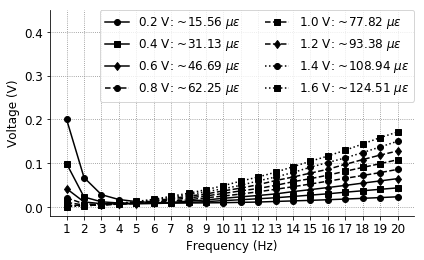

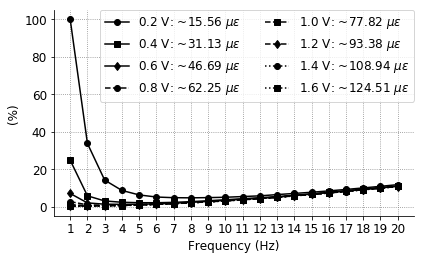

In [11]:
_main_post = main_postprocess(sim_type, sim_param, sensor, csv_path=processed_data, ustrainUnits=False, verbose=True, save2fig=True)